# Complete Streamlined Collaboration Analysis: Human-Human-GPT vs Human-RL

This comprehensive notebook provides a streamlined version of the collaboration analysis, merging data from:
1. **Human-Human-GPT study** (3 conditions: human, gpt-4.1-mini, mixed types)
2. **Human-RL study** (2 conditions: individual rl, joint rl)

**Complete Analysis includes ALL 10 original figures:**
1. Collaboration success rates
2. Total steps analysis (main + by commitment status)
3. Questionnaire analysis (AI detection, collaboration rating, play again intention)
4. Commitment patterns (human + AI, main + by distance conditions)
5. Combined human-AI commitment analysis

All statistical comparisons and visualizations are preserved from the original analysis.

## Setup and Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from scipy.stats import chi2_contingency
import ast
import glob
import os
from itertools import combinations
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Define consistent color scheme for all conditions
CONDITION_COLORS = {
    'human': '#2E86C1',        # Blue
    'gpt-4.1-mini': '#E74C3C', # Red
    'individual_rl': '#28B463', # Green
    'joint_rl': '#F39C12'      # Orange
}

print("Libraries loaded and styling configured!")

Libraries loaded and styling configured!


## Global Configuration and Utility Functions

In [ ]:
# Global configuration
game_type_order = ["human", "gpt-4.1-mini", "individual_rl", "joint_rl"]
game_type_labels = ['Human', 'GPT-4.1-mini', 'Individual RL', 'Joint RL']

def rename_distance_condition_human_ai(row, study_type):
    """Rename distanceCondition values to be more intuitive for human-AI games."""
    distance_condition = row.get('distanceCondition')

    if pd.isna(distance_condition) or distance_condition in ['no_new_goal', 'equal_to_both']:
        return distance_condition

    if study_type == 'Human-RL':
        mapping = {
            'closer_to_player1': 'closer_to_human',
            'closer_to_player2': 'closer_to_AI',
            'farther_to_player1': 'farther_to_human',
            'equal_to_player1': 'equal_to_human'
        }
        return mapping.get(distance_condition, distance_condition)

    elif study_type == 'Human-Human-GPT':
        human_index = row.get('humanPlayerIndex', 0)

        if human_index == 0:
            mapping = {
                'closer_to_player1': 'closer_to_human',
                'closer_to_player2': 'closer_to_AI',
                'farther_to_player1': 'farther_to_human',
                'equal_to_player1': 'equal_to_human'
            }
        else:
            mapping = {
                'closer_to_player1': 'closer_to_AI',
                'closer_to_player2': 'closer_to_human',
                'farther_to_player1': 'farther_to_AI',
                'equal_to_player1': 'equal_to_AI'
            }

        return mapping.get(distance_condition, distance_condition)

    return distance_condition

def calculate_human_commitment_2p3g_merged(row, study_type):
    """Calculate commitment for human player in 2P3G based on study and player index"""
    shared_goal = row.get('firstDetectedSharedGoal')

    if pd.isna(shared_goal):
        return np.nan

    if study_type == 'Human-Human-GPT':
        human_index = row.get('humanPlayerIndex')
        if pd.isna(human_index):
            human_index = 0

        if human_index == 0:
            human_final_goal = row.get('player1FinalReachedGoal')
        else:
            human_final_goal = row.get('player2FinalReachedGoal')

    elif study_type == 'Human-RL':
        human_final_goal = row.get('player1FinalReachedGoal')

    else:
        return np.nan

    if pd.isna(human_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        human_final_goal = int(human_final_goal)
        return 1 if shared_goal == human_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_ai_commitment_2p3g(row, study_type):
    """Calculate AI commitment in 2P3G as whether AI's final reached goal equals the first detected shared goal."""
    shared_goal = row.get('firstDetectedSharedGoal')
    if pd.isna(shared_goal):
        return np.nan

    if study_type == 'Human-RL':
        ai_final_goal = row.get('player2FinalReachedGoal')
    elif study_type == 'Human-Human-GPT':
        human_index = row.get('humanPlayerIndex')
        if pd.isna(human_index):
            human_index = 0
        ai_index = 1 if human_index == 0 else 0
        ai_final_goal = row.get('player1FinalReachedGoal') if ai_index == 0 else row.get('player2FinalReachedGoal')
    else:
        return np.nan

    if pd.isna(ai_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        ai_final_goal = int(ai_final_goal)
        return 1 if ai_final_goal == shared_goal else 0
    except (ValueError, TypeError):
        return np.nan

def extract_participant_id(file_id, study):
    """Extract participant ID from file name"""
    parts = file_id.split('_')
    if len(parts) >= 3:
        return parts[2]
    return file_id

def calculate_trajectory_steps(row):
    """Calculate total steps from trajectory lengths"""
    try:
        p1_traj = row['player1Trajectory']
        p2_traj = row['player2Trajectory']

        if isinstance(p1_traj, str):
            p1_traj = ast.literal_eval(p1_traj)
        if isinstance(p2_traj, str):
            p2_traj = ast.literal_eval(p2_traj)

        p1_steps = len(p1_traj) if p1_traj else 0
        p2_steps = len(p2_traj) if p2_traj else 0

        return p1_steps + p2_steps
    except:
        return 0

def is_valid_trajectory(trajectory):
    """Check if trajectory has valid consecutive steps (distance <= 1)"""
    try:
        if isinstance(trajectory, str):
            trajectory = ast.literal_eval(trajectory)

        if not trajectory or len(trajectory) < 2:
            return True

        for i in range(1, len(trajectory)):
            prev_pos = trajectory[i-1]
            curr_pos = trajectory[i]
            distance = abs(curr_pos[0] - prev_pos[0]) + abs(curr_pos[1] - prev_pos[1])
            if distance > 1:
                return False

        return True
    except:
        return False

print("✅ Utility functions defined")



✅ Utility functions defined


## Comprehensive Data Loading Functions

In [ ]:
def load_all_data():
    """Load all datasets needed for complete analysis"""

    print("=== LOADING ALL DATASETS ===")

    # 1. Load Human-Human-GPT collaboration success data
    try:
        hh_gpt_success = pd.read_csv('human-human-with-gpt-fallback/collaboration_success_by_gameType_participants.csv')
        hh_gpt_success['study'] = 'Human-Human-GPT'
        hh_gpt_success = hh_gpt_success.rename(columns={'participant_id': 'participantID'})
        print(f"✅ Human-Human-GPT success data: {len(hh_gpt_success)} participants")
    except Exception as e:
        print(f"❌ Error loading HH-GPT success data: {e}")
        hh_gpt_success = pd.DataFrame()

    # 2. Load Human-RL data from Excel files
    try:
        rl_data_dir = Path('human-RLs/data-original')
        excel_files = [f for f in rl_data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

        rl_data_frames = []
        for file in excel_files:
            try:
                df = pd.read_excel(file)
                participant_id = file.name.split('_')[2]
                df['participantID'] = participant_id
                df['file_id'] = file.name
                df['study'] = 'Human-RL'
                rl_data_frames.append(df)
            except Exception as e:
                print(f"Warning: Error loading {file.name}: {e}")

        if rl_data_frames:
            rl_combined_data = pd.concat(rl_data_frames, ignore_index=True)
            rl_filtered_data = rl_combined_data[rl_combined_data['experimentType'] == '2P3G'].copy()

            # Calculate success rates
            rl_success = rl_filtered_data.groupby(['participantID', 'rlAgentType'])['collaborationSucceeded'].mean().reset_index()
            rl_success['success_rate'] = rl_success['collaborationSucceeded']
            rl_success['game_type'] = rl_success['rlAgentType'].map({'individual': 'individual_rl', 'joint': 'joint_rl'})
            rl_success['study'] = 'Human-RL'

            print(f"✅ Human-RL success data: {len(rl_success)} participants")
        else:
            rl_success = pd.DataFrame()
            rl_combined_data = pd.DataFrame()
            rl_filtered_data = pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading RL data: {e}")
        rl_success = pd.DataFrame()
        rl_combined_data = pd.DataFrame()
        rl_filtered_data = pd.DataFrame()

    # 3. Load Human-Human-GPT trial-level data
    try:
        classification_df = pd.read_csv('human-human-with-gpt-fallback/file_classification_summary.csv')
        hh_gpt_files = glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx')

        hh_gpt_trial_data = []
        for file in hh_gpt_files:
            try:
                excel_file = pd.ExcelFile(file)
                if 'ExperimentData' in excel_file.sheet_names:
                    exp_df = pd.read_excel(file, sheet_name='ExperimentData')
                    exp_df['file_id'] = os.path.basename(file)
                    exp_df['study'] = 'Human-Human-GPT'

                    # Filter for 2P3G successful trials
                    trials_2p3g = exp_df[(exp_df['experimentType'] == '2P3G') & (exp_df['collaborationSucceeded'] == True)].copy()

                    if len(trials_2p3g) > 0:
                        # Clean trajectories
                        valid_p1 = trials_2p3g['player1Trajectory'].apply(is_valid_trajectory)
                        valid_p2 = trials_2p3g['player2Trajectory'].apply(is_valid_trajectory)
                        trials_2p3g = trials_2p3g[valid_p1 & valid_p2].copy()

                        if len(trials_2p3g) > 0:
                            # Calculate steps and rename distance conditions
                            trials_2p3g['total_steps'] = trials_2p3g.apply(calculate_trajectory_steps, axis=1)
                            trials_2p3g['distanceCondition_renamed'] = trials_2p3g.apply(
                                lambda row: rename_distance_condition_human_ai(row, 'Human-Human-GPT'), axis=1
                            )
                            trials_2p3g['human_commitment'] = trials_2p3g.apply(
                                lambda row: calculate_human_commitment_2p3g_merged(row, 'Human-Human-GPT'), axis=1
                            )
                            trials_2p3g['ai_commitment'] = trials_2p3g.apply(
                                lambda row: calculate_ai_commitment_2p3g(row, 'Human-Human-GPT'), axis=1
                            )
                            hh_gpt_trial_data.append(trials_2p3g)
            except Exception as e:
                print(f"Warning: Error loading HH-GPT trial data from {file}: {e}")

        if hh_gpt_trial_data:
            hh_gpt_combined_trials = pd.concat(hh_gpt_trial_data, ignore_index=True)
            # Merge with classification
            hh_gpt_combined_trials = hh_gpt_combined_trials.merge(
                classification_df[['file_name', 'game_type']],
                left_on='file_id', right_on='file_name', how='left'
            )
            print(f"✅ Human-Human-GPT trial data: {len(hh_gpt_combined_trials)} trials")
        else:
            hh_gpt_combined_trials = pd.DataFrame()
    except Exception as e:
        print(f"❌ Error loading HH-GPT trial data: {e}")
        hh_gpt_combined_trials = pd.DataFrame()

    # 4. Process RL trial-level data
    if not rl_filtered_data.empty:
        try:
            # Add distance renaming and commitment calculation
            rl_filtered_data['distanceCondition_renamed'] = rl_filtered_data.apply(
                lambda row: rename_distance_condition_human_ai(row, 'Human-RL'), axis=1
            )
            rl_filtered_data['human_commitment'] = rl_filtered_data.apply(
                lambda row: calculate_human_commitment_2p3g_merged(row, 'Human-RL'), axis=1
            )
            rl_filtered_data['ai_commitment'] = rl_filtered_data.apply(
                lambda row: calculate_ai_commitment_2p3g(row, 'Human-RL'), axis=1
            )
            rl_filtered_data['game_type'] = rl_filtered_data['rlAgentType'].map({'individual': 'individual_rl', 'joint': 'joint_rl'})
            rl_filtered_data['total_steps'] = rl_filtered_data.apply(calculate_trajectory_steps, axis=1)
            print(f"✅ Human-RL trial data processed: {len(rl_filtered_data)} trials")
        except Exception as e:
            print(f"❌ Error processing RL trial data: {e}")

    # 5. Load questionnaire data
    questionnaire_data = []

    # RL questionnaire data
    try:
        for file in glob.glob('human-RLs/data-original/*.xlsx'):
            excel_file = pd.ExcelFile(file)
            if 'Questionnaire Data' in excel_file.sheet_names and 'Experiment Data' in excel_file.sheet_names:
                quest_df = pd.read_excel(file, sheet_name='Questionnaire Data')
                exp_df = pd.read_excel(file, sheet_name='Experiment Data')

                if 'rlAgentType' in exp_df.columns and len(exp_df) > 0:
                    rl_agent_type = exp_df['rlAgentType'].iloc[0]
                    quest_df['study'] = 'Human-RL'
                    quest_df['game_type'] = 'individual_rl' if rl_agent_type == 'individual' else 'joint_rl'
                    questionnaire_data.append(quest_df)
    except Exception as e:
        print(f"Warning: Error loading RL questionnaire data: {e}")

    # HH-GPT questionnaire data
    try:
        for file in glob.glob('human-human-with-gpt-fallback/data-original/*.xlsx'):
            excel_file = pd.ExcelFile(file)
            if 'Questionnaire' in excel_file.sheet_names:
                quest_df = pd.read_excel(file, sheet_name='Questionnaire')
                quest_df['study'] = 'Human-Human-GPT'
                quest_df['file_id'] = os.path.basename(file)

                # Merge with classification
                file_class = classification_df[classification_df['file_name'] == os.path.basename(file)]
                if not file_class.empty:
                    quest_df['game_type'] = file_class['game_type'].iloc[0]
                    questionnaire_data.append(quest_df)
    except Exception as e:
        print(f"Warning: Error loading HH-GPT questionnaire data: {e}")

    # Combine all datasets
    datasets = {
        'collaboration_success': pd.concat([hh_gpt_success, rl_success], ignore_index=True) if not hh_gpt_success.empty and not rl_success.empty else pd.DataFrame(),
        'trial_data': pd.concat([hh_gpt_combined_trials, rl_filtered_data], ignore_index=True) if not hh_gpt_combined_trials.empty and not rl_filtered_data.empty else pd.DataFrame(),
        'questionnaire': pd.concat(questionnaire_data, ignore_index=True) if questionnaire_data else pd.DataFrame(),
        'rl_trial_data': rl_filtered_data,
        'hh_gpt_trial_data': hh_gpt_combined_trials
    }

    # Filter questionnaire to analysis game types
    if not datasets['questionnaire'].empty:
        datasets['questionnaire'] = datasets['questionnaire'][
            datasets['questionnaire']['game_type'].isin(game_type_order)
        ]

    print(f"\n✅ Data loading complete!")
    print(f"📊 Collaboration success: {len(datasets['collaboration_success'])} participants")
    print(f"📊 Trial data: {len(datasets['trial_data'])} trials")
    print(f"📊 Questionnaire: {len(datasets['questionnaire'])} responses")

    return datasets

# Load all data
data = load_all_data()
print("✅ All datasets loaded and ready for analysis!")

=== LOADING ALL DATASETS ===
✅ Human-Human-GPT success data: 50 participants
✅ Human-RL success data: 60 participants
✅ Human-Human-GPT trial data: 471 trials
✅ Human-RL trial data processed: 720 trials

✅ Data loading complete!
📊 Collaboration success: 110 participants
📊 Trial data: 1191 trials
📊 Questionnaire: 99 responses
✅ All datasets loaded and ready for analysis!


## 1. Collaboration Success Analysis

=== COLLABORATION SUCCESS ANALYSIS ===


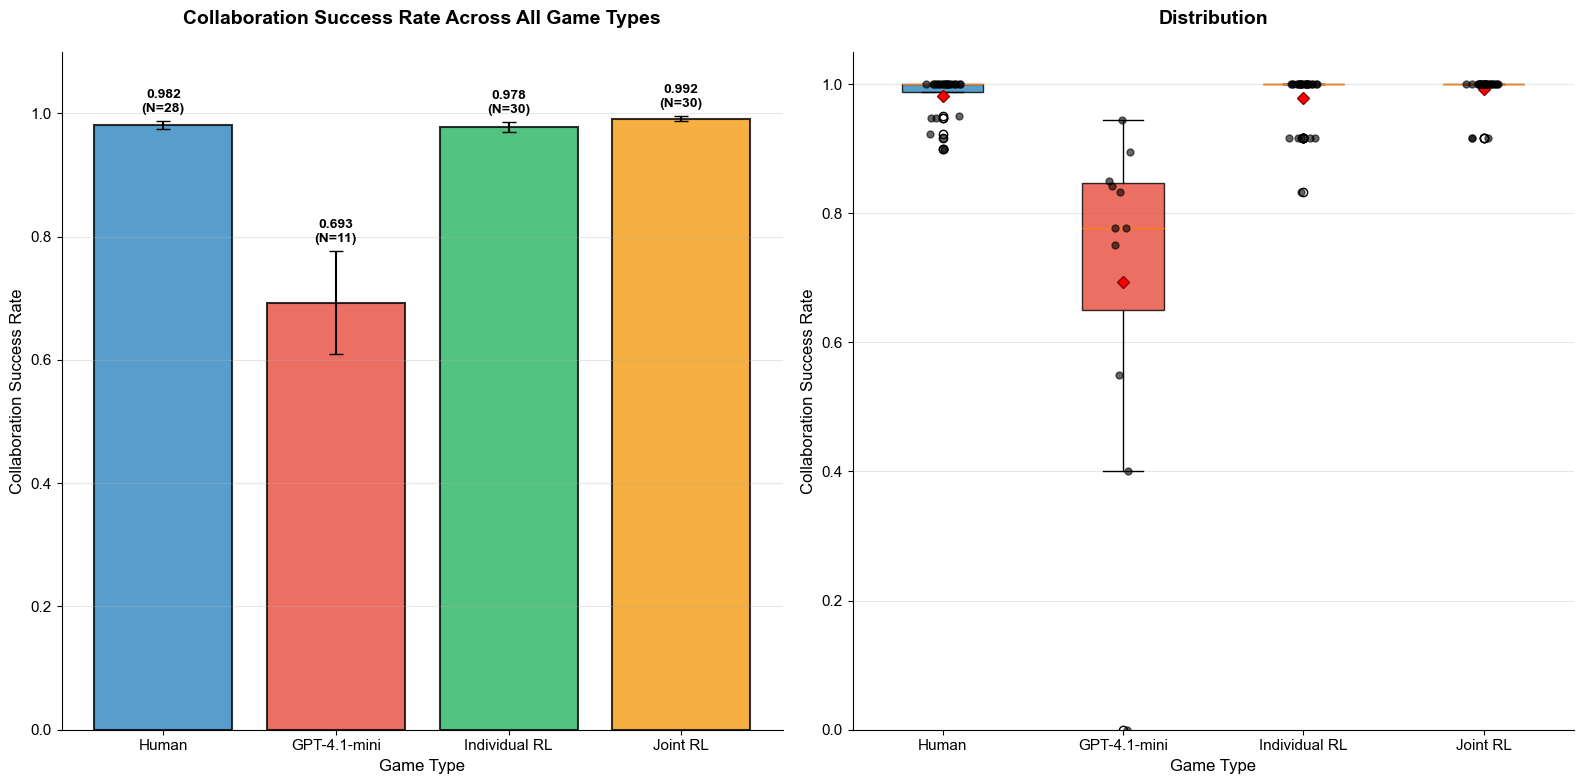


=== COLLABORATION SUCCESS STATISTICS ===
Human: M = 0.982, SD = 0.034, N = 28
GPT-4.1-mini: M = 0.693, SD = 0.278, N = 11
Individual RL: M = 0.978, SD = 0.043, N = 30
Joint RL: M = 0.992, SD = 0.025, N = 30


In [16]:
# Figure 2: Collaboration Success Analysis (merged_collaboration_success_analysis.png)
if not data['collaboration_success'].empty:
    print("=== COLLABORATION SUCCESS ANALYSIS ===")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    available_types = [gt for gt in game_type_order if gt in data['collaboration_success']['game_type'].values]
    available_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_types]
    available_colors = [CONDITION_COLORS[gt] for gt in available_types]

    plot_data, plot_errors, plot_ns = [], [], []

    for game_type in available_types:
        data_subset = data['collaboration_success'][data['collaboration_success']['game_type'] == game_type]['success_rate']
        plot_data.append(data_subset.mean())
        plot_errors.append(data_subset.std() / np.sqrt(len(data_subset)))
        plot_ns.append(len(data_subset))

    # Bar plot
    bars = ax1.bar(available_labels, plot_data, yerr=plot_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
        ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.01,
                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.set_title('Collaboration Success Rate Across All Game Types', fontweight='bold', pad=20)
    ax1.set_ylabel('Collaboration Success Rate')
    ax1.set_xlabel('Game Type')
    ax1.set_ylim(0, 1.1)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Box plot
    box_data = [data['collaboration_success'][data['collaboration_success']['game_type'] == gt]['success_rate'].values
                for gt in available_types]

    bp = ax2.boxplot(box_data, labels=available_labels, patch_artist=True,
                     showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    for patch, color in zip(bp['boxes'], available_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    for i, game_type in enumerate(available_types):
        data_subset = data['collaboration_success'][data['collaboration_success']['game_type'] == game_type]['success_rate']
        x_positions = np.random.normal(i+1, 0.04, size=len(data_subset))
        ax2.scatter(x_positions, data_subset, color='black', alpha=0.6, s=25, zorder=3)

    ax2.set_title('Distribution', fontweight='bold', pad=20)
    ax2.set_ylabel('Collaboration Success Rate')
    ax2.set_xlabel('Game Type')
    ax2.set_ylim(0, 1.05)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_collaboration_success_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Statistical analysis
    print("\n=== COLLABORATION SUCCESS STATISTICS ===")
    for game_type in available_types:
        data_subset = data['collaboration_success'][data['collaboration_success']['game_type'] == game_type]['success_rate']
        label = available_labels[available_types.index(game_type)]
        print(f"{label}: M = {data_subset.mean():.3f}, SD = {data_subset.std():.3f}, N = {len(data_subset)}")

else:
    print("❌ No collaboration success data available")

## 2. Total Steps Analysis

=== TOTAL STEPS ANALYSIS ===


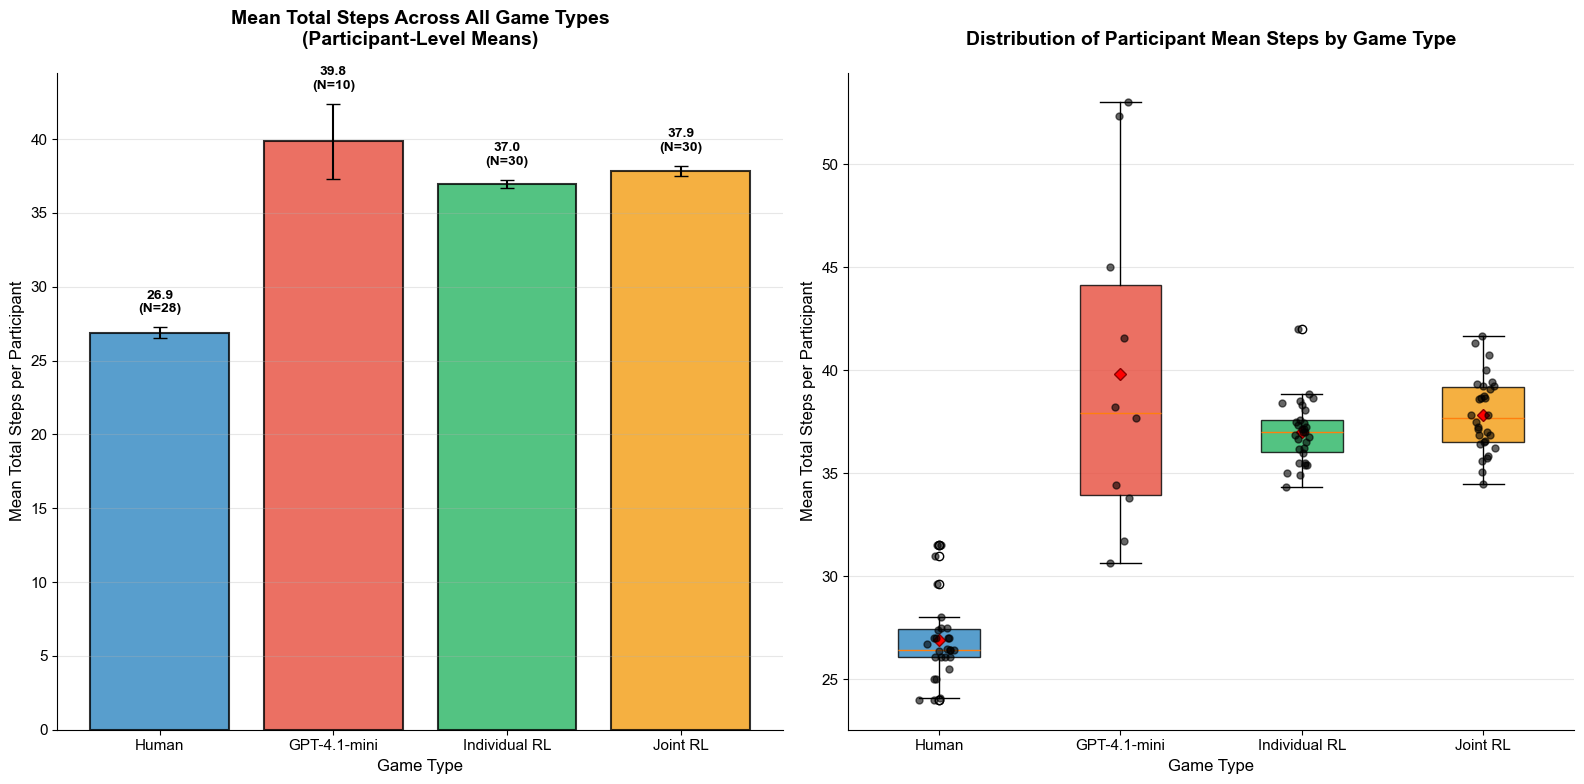

✅ Total steps analysis complete with 108 participants


In [17]:
# Figure 3: Total Steps Analysis (merged_total_steps_analysis.png)
if not data['trial_data'].empty:
    print("=== TOTAL STEPS ANALYSIS ===")

    # Calculate participant-level means
    steps_data = data['trial_data'][data['trial_data']['total_steps'] > 0].copy()
    steps_data['participant_id'] = steps_data.apply(lambda row: extract_participant_id(row['file_id'], row['study']), axis=1)

    participant_steps = steps_data.groupby(['participant_id', 'game_type', 'study'])['total_steps'].mean().reset_index()
    participant_steps['participant_mean_steps'] = participant_steps['total_steps']

    available_steps_types = [gt for gt in game_type_order if gt in participant_steps['game_type'].values]
    available_steps_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_steps_types]
    available_steps_colors = [CONDITION_COLORS[gt] for gt in available_steps_types]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Bar plot
    plot_data, plot_errors, plot_ns = [], [], []

    for game_type in available_steps_types:
        participant_data = participant_steps[participant_steps['game_type'] == game_type]['participant_mean_steps']
        plot_data.append(participant_data.mean())
        plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))
        plot_ns.append(len(participant_data))

    bars = ax1.bar(available_steps_labels, plot_data, yerr=plot_errors, capsize=5,
                   alpha=0.8, color=available_steps_colors, edgecolor='black', linewidth=1.5)

    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
        ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + max(plot_data)*0.02,
                f'{mean_val:.1f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax1.set_title('Mean Total Steps Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
    ax1.set_ylabel('Mean Total Steps per Participant')
    ax1.set_xlabel('Game Type')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Box plot
    box_data = [participant_steps[participant_steps['game_type'] == gt]['participant_mean_steps'].values
                for gt in available_steps_types]

    bp = ax2.boxplot(box_data, labels=available_steps_labels, patch_artist=True,
                     showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    for patch, color in zip(bp['boxes'], available_steps_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    for i, game_type in enumerate(available_steps_types):
        participant_data = participant_steps[participant_steps['game_type'] == game_type]['participant_mean_steps']
        x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
        ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

    ax2.set_title('Distribution of Participant Mean Steps by Game Type', fontweight='bold', pad=20)
    ax2.set_ylabel('Mean Total Steps per Participant')
    ax2.set_xlabel('Game Type')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_total_steps_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Total steps analysis complete with {len(participant_steps)} participants")

else:
    print("❌ No trial data available for steps analysis")

In [ ]:
# Figure 2.5: Human Trajectory Steps Analysis
if not data['trial_data'].empty:
    print("=== HUMAN TRAJECTORY STEPS ANALYSIS ===")

    def get_human_trajectory_steps(row):
        """Get trajectory steps for human player based on game type and study"""
        try:
            study = row['study']
            game_type = row['game_type']
            
            # For Human-RL studies, human is always player 1
            if study == 'Human-RL':
                human_traj = row['player1Trajectory']
            # For Human-Human-GPT studies, check humanPlayerIndex
            elif study == 'Human-Human-GPT':
                human_index = row.get('humanPlayerIndex', 0)  # Default to 0 if not specified
                if human_index == 0:
                    human_traj = row['player1Trajectory']
                else:
                    human_traj = row['player2Trajectory']
            else:
                return 0
                
            # Parse trajectory if it's a string
            if isinstance(human_traj, str):
                human_traj = ast.literal_eval(human_traj)
                
            return len(human_traj) if human_traj else 0
            
        except Exception as e:
            return 0

    # Calculate human trajectory steps for each trial
    human_steps_data = data['trial_data'].copy()
    human_steps_data['human_steps'] = human_steps_data.apply(get_human_trajectory_steps, axis=1)
    
    # Filter out invalid data
    human_steps_data = human_steps_data[human_steps_data['human_steps'] > 0].copy()
    
    if not human_steps_data.empty:
        # Calculate participant-level means
        human_steps_data['participant_id'] = human_steps_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )
        
        participant_human_steps = human_steps_data.groupby(
            ['participant_id', 'game_type', 'study']
        )['human_steps'].mean().reset_index()
        participant_human_steps['mean_human_steps'] = participant_human_steps['human_steps']

        available_human_types = [gt for gt in game_type_order if gt in participant_human_steps['game_type'].values]
        available_human_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_human_types]
        available_human_colors = [CONDITION_COLORS[gt] for gt in available_human_types]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Bar plot
        plot_data, plot_errors, plot_ns = [], [], []

        for game_type in available_human_types:
            participant_data = participant_human_steps[participant_human_steps['game_type'] == game_type]['mean_human_steps']
            plot_data.append(participant_data.mean())
            plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))
            plot_ns.append(len(participant_data))

        bars = ax1.bar(available_human_labels, plot_data, yerr=plot_errors, capsize=5,
                       alpha=0.8, color=available_human_colors, edgecolor='black', linewidth=1.5)

        for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + max(plot_data)*0.02,
                    f'{mean_val:.1f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax1.set_title('Mean Human Trajectory Steps Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
        ax1.set_ylabel('Mean Human Trajectory Steps per Participant')
        ax1.set_xlabel('Game Type')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # Box plot
        box_data = [participant_human_steps[participant_human_steps['game_type'] == gt]['mean_human_steps'].values
                    for gt in available_human_types]

        bp = ax2.boxplot(box_data, labels=available_human_labels, patch_artist=True,
                         showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

        for patch, color in zip(bp['boxes'], available_human_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

        for i, game_type in enumerate(available_human_types):
            participant_data = participant_human_steps[participant_human_steps['game_type'] == game_type]['mean_human_steps']
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

        ax2.set_title('Distribution of Human Trajectory Steps by Game Type', fontweight='bold', pad=20)
        ax2.set_ylabel('Mean Human Trajectory Steps per Participant')
        ax2.set_xlabel('Game Type')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig('merged_human_trajectory_steps_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print statistics
        print("\n=== HUMAN TRAJECTORY STEPS STATISTICS ===")
        for game_type in available_human_types:
            participant_data = participant_human_steps[participant_human_steps['game_type'] == game_type]['mean_human_steps']
            label = available_human_labels[available_human_types.index(game_type)]
            print(f"{label}: M = {participant_data.mean():.2f}, SD = {participant_data.std():.2f}, N = {len(participant_data)}")

        print(f"✅ Human trajectory steps analysis complete with {len(participant_human_steps)} participants")
    else:
        print("❌ No valid human trajectory data available")
else:
    print("❌ No trial data available for human trajectory steps analysis")

## 2.5. Human Trajectory Steps Analysis

## 3. Steps by Commitment Status

=== STEPS BY COMMITMENT STATUS ANALYSIS ===


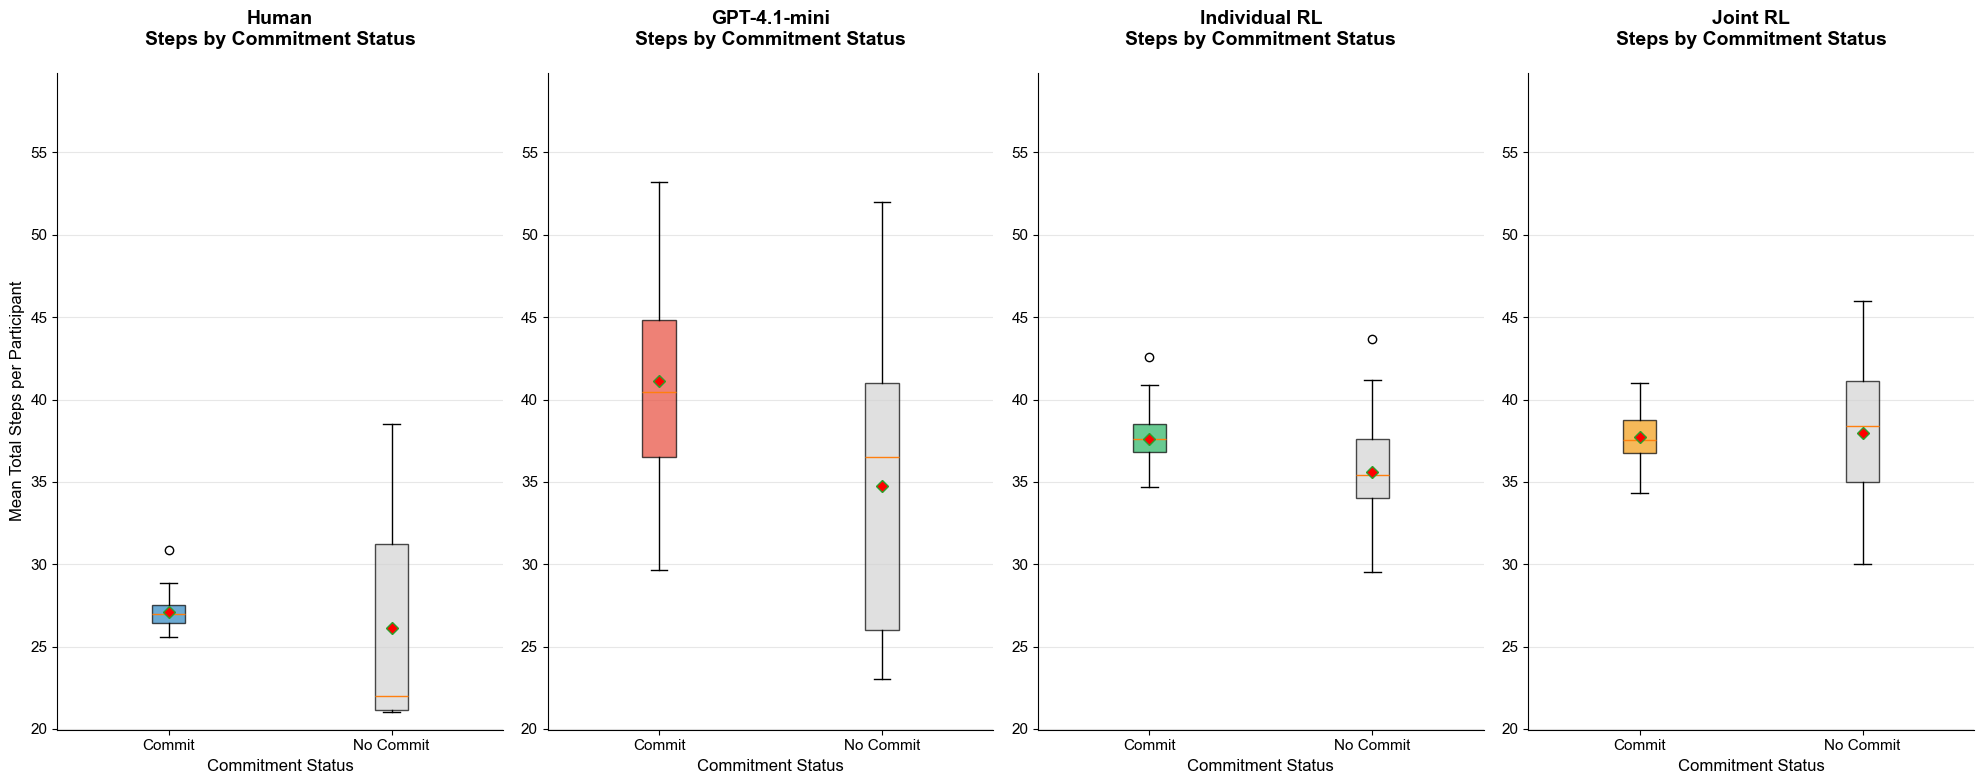

✅ Steps by commitment analysis complete


In [18]:
# Figure 4: Steps by Commitment Status (merged_steps_by_commitment_analysis.png)
if not data['trial_data'].empty:
    print("=== STEPS BY COMMITMENT STATUS ANALYSIS ===")

    # Merge steps with commitment data
    steps_commitment_data = data['trial_data'][
        (data['trial_data']['total_steps'] > 0) &
        (~pd.isna(data['trial_data']['human_commitment']))
    ].copy()

    if not steps_commitment_data.empty:
        steps_commitment_data['participant_id'] = steps_commitment_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )
        steps_commitment_data['commitment_status'] = steps_commitment_data['human_commitment'].map({
            1: 'Commit', 0: 'No Commit'
        })

        # Calculate participant-level means by commitment status
        participant_steps_commitment = steps_commitment_data.groupby(
            ['participant_id', 'game_type', 'study', 'commitment_status']
        )['total_steps'].mean().reset_index()
        participant_steps_commitment.rename(columns={'total_steps': 'mean_steps'}, inplace=True)

        available_commit_types = [gt for gt in game_type_order if gt in participant_steps_commitment['game_type'].values]
        available_commit_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_commit_types]
        available_commit_colors = [CONDITION_COLORS[gt] for gt in available_commit_types]

        # Calculate global y-axis range
        all_steps_data = participant_steps_commitment['mean_steps']
        y_min = all_steps_data.min() * 0.95
        y_max = all_steps_data.max() * 1.05

        fig, axes = plt.subplots(1, len(available_commit_types), figsize=(5 * len(available_commit_types), 8))
        if len(available_commit_types) == 1:
            axes = [axes]

        for i, game_type in enumerate(available_commit_types):
            ax = axes[i]
            game_label = available_commit_labels[i]
            game_color = available_commit_colors[i]

            game_data = participant_steps_commitment[participant_steps_commitment['game_type'] == game_type]

            if len(game_data) > 0:
                commit_data = game_data[game_data['commitment_status'] == 'Commit']['mean_steps']
                no_commit_data = game_data[game_data['commitment_status'] == 'No Commit']['mean_steps']

                box_data, box_labels, box_colors = [], [], []

                if len(commit_data) > 0:
                    box_data.append(commit_data.values)
                    box_labels.append('Commit')
                    box_colors.append(game_color)

                if len(no_commit_data) > 0:
                    box_data.append(no_commit_data.values)
                    box_labels.append('No Commit')
                    box_colors.append('lightgray')

                if box_data:
                    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                                   showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red'})

                    for patch, color in zip(bp['boxes'], box_colors):
                        patch.set_facecolor(color)
                        patch.set_alpha(0.7)

            ax.set_title(f'{game_label}\nSteps by Commitment Status', fontweight='bold', pad=20)
            ax.set_ylabel('Mean Total Steps per Participant' if i == 0 else '')
            ax.set_xlabel('Commitment Status')
            ax.set_ylim(y_min, y_max)
            ax.grid(True, alpha=0.3, axis='y')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig('merged_steps_by_commitment_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Steps by commitment analysis complete")
    else:
        print("❌ No data available for steps by commitment analysis")
else:
    print("❌ No trial data available for steps by commitment analysis")

## 4. Questionnaire Analysis (AI Detection, Collaboration Rating, Play Again)

=== COMPREHENSIVE QUESTIONNAIRE ANALYSIS ===
Questionnaire responses: 99
Game types: game_type
joint_rl         30
individual_rl    30
human            28
gpt-4.1-mini     11
Name: count, dtype: int64


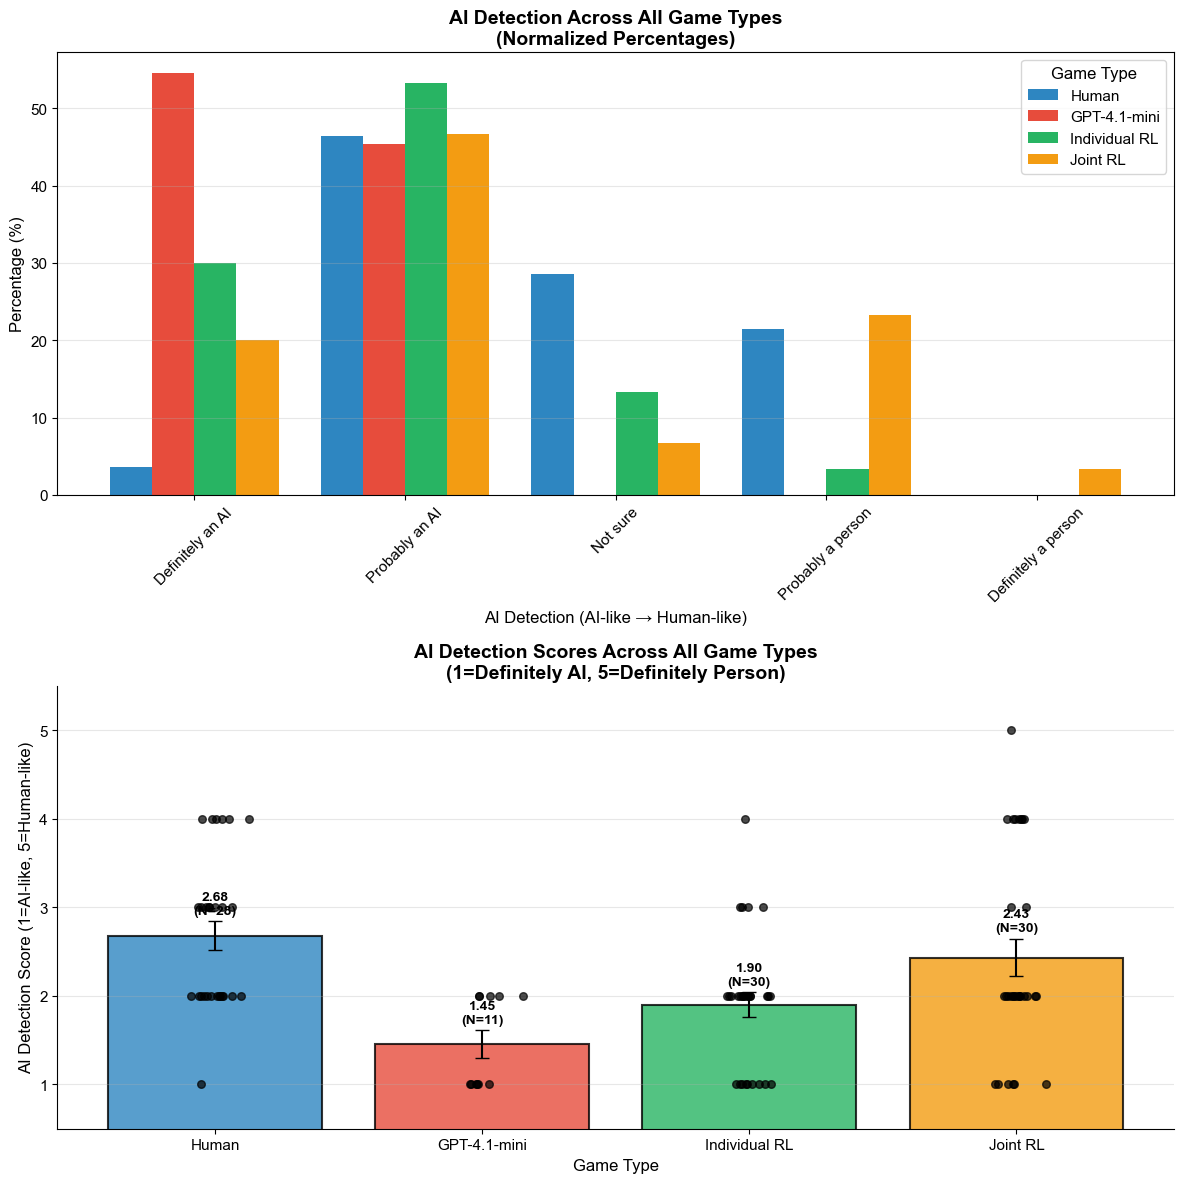

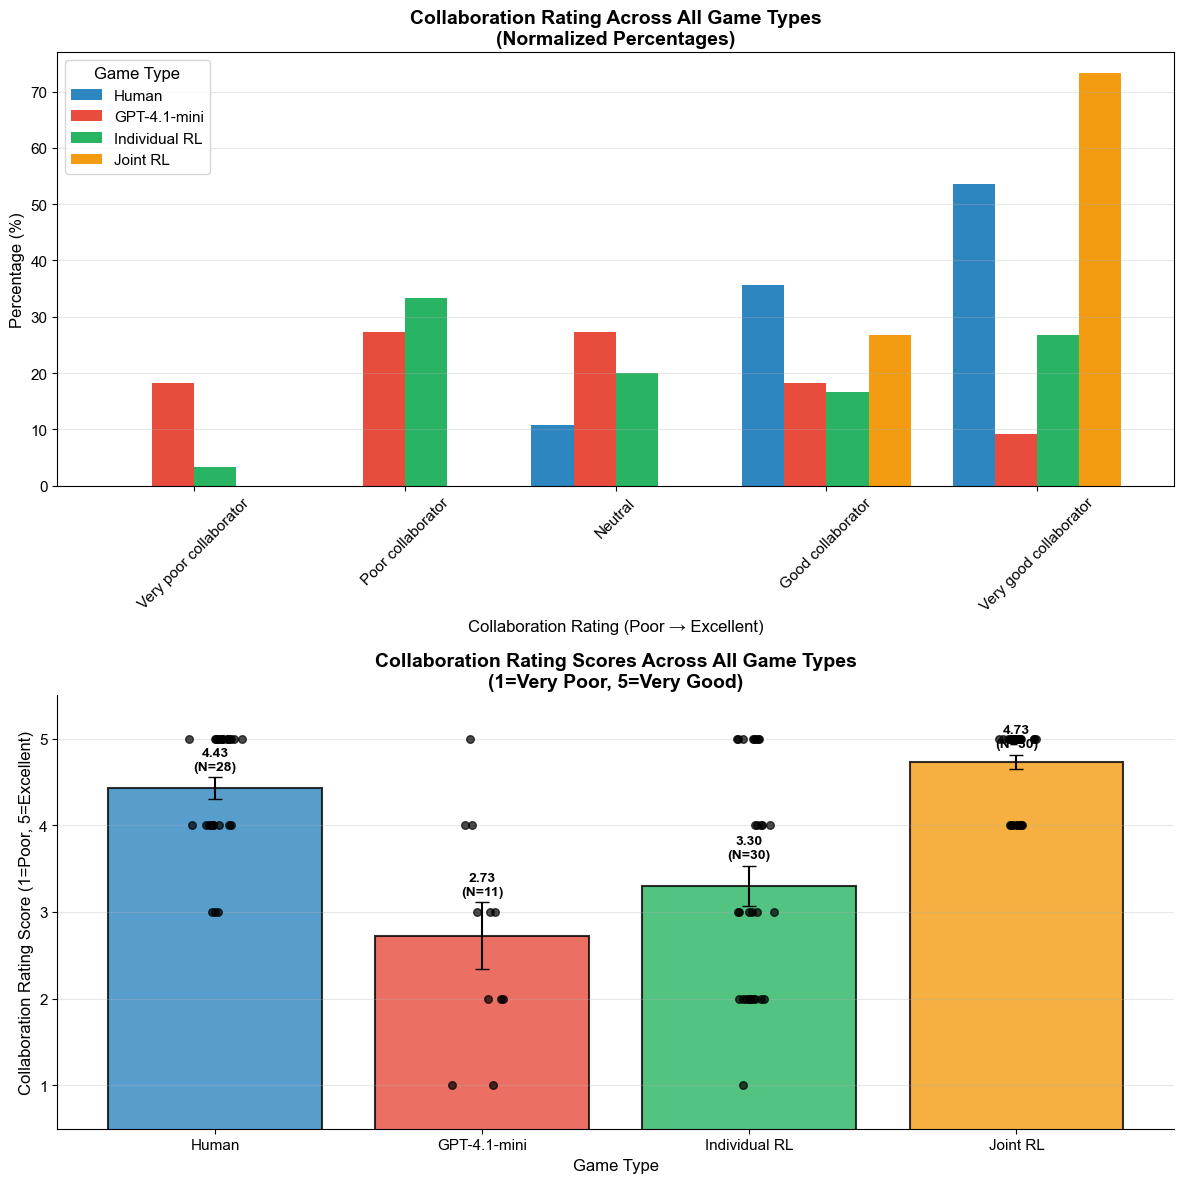

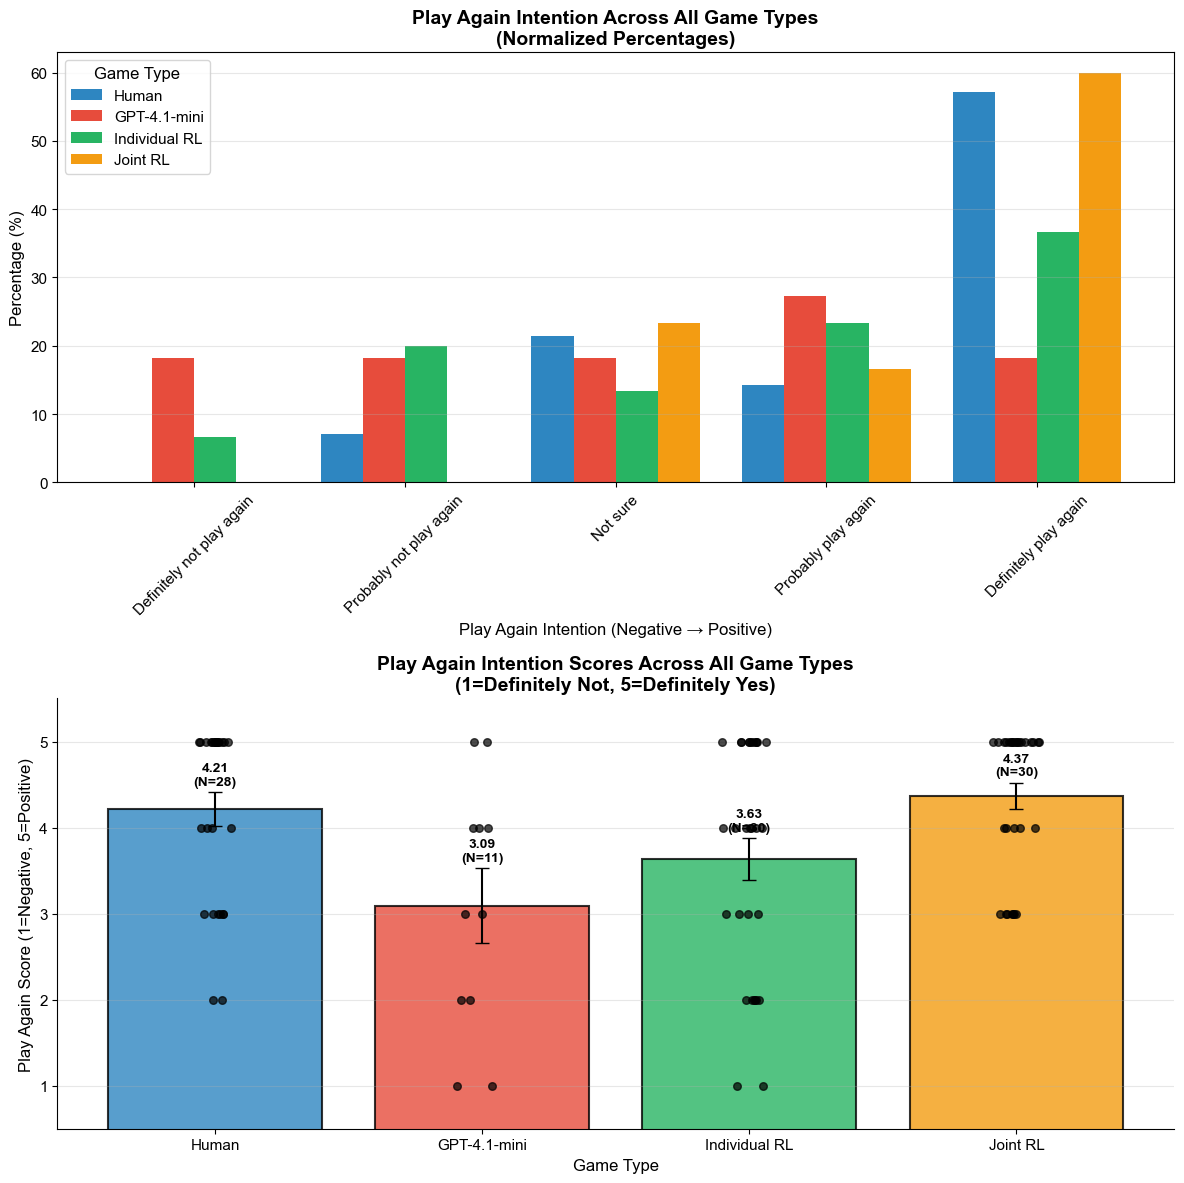

✅ Questionnaire analysis complete


In [19]:
# Figures 5-7: AI Detection, Collaboration Rating, Play Again Analysis
if not data['questionnaire'].empty:
    print("=== COMPREHENSIVE QUESTIONNAIRE ANALYSIS ===")

    # Define ordinal mappings from TimelineManager.js
    ai_detection_order = ['Definitely a person', 'Probably a person', 'Not sure', 'Probably an AI', 'Definitely an AI']
    collaboration_order = ['Very poor collaborator', 'Poor collaborator', 'Neutral', 'Good collaborator', 'Very good collaborator']
    play_again_order = ['Definitely not play again', 'Probably not play again', 'Not sure', 'Probably play again', 'Definitely play again']

    # Convert to categorical
    quest_data = data['questionnaire'].copy()
    quest_data['ai_detection_cat'] = pd.Categorical(quest_data['ai_detection'], categories=ai_detection_order, ordered=True)
    quest_data['collaboration_rating_cat'] = pd.Categorical(quest_data['collaboration_rating'], categories=collaboration_order, ordered=True)
    quest_data['play_again_cat'] = pd.Categorical(quest_data['play_again'], categories=play_again_order, ordered=True)

    available_types = [gt for gt in game_type_order if gt in quest_data['game_type'].values]
    available_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_types]
    available_colors = [CONDITION_COLORS[gt] for gt in available_types]

    print(f"Questionnaire responses: {len(quest_data)}")
    print(f"Game types: {quest_data['game_type'].value_counts()}")

    # AI Detection Analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    ai_data = quest_data.groupby(['game_type', 'ai_detection_cat'], observed=True).size().unstack(fill_value=0)
    ai_data_ordered = ai_data.loc[available_types]
    ai_norm = ai_data_ordered.div(ai_data_ordered.sum(axis=1), axis=0) * 100
    ai_norm_reversed = ai_norm.T.iloc[::-1]
    ai_norm_reversed.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)

    ax1.set_title('AI Detection Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('AI Detection (AI-like → Human-like)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # AI Detection Scores
    ai_detection_score_mapping = {'Definitely an AI': 1, 'Probably an AI': 2, 'Not sure': 3, 'Probably a person': 4, 'Definitely a person': 5}
    quest_data['ai_detection_score'] = quest_data['ai_detection'].map(ai_detection_score_mapping)

    score_data, score_errors = [], []
    for game_type in available_types:
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['ai_detection_score'].dropna()
        score_data.append(scores.mean())
        score_errors.append(scores.std() / np.sqrt(len(scores)))

    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for i, game_type in enumerate(available_types):
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['ai_detection_score'].dropna()
        x_positions = np.random.normal(i, 0.04, size=len(scores))
        ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(quest_data[quest_data['game_type'] == available_types[i]]['ai_detection_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('AI Detection Scores Across All Game Types\n(1=Definitely AI, 5=Definitely Person)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('AI Detection Score (1=AI-like, 5=Human-like)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_ai_detection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Collaboration Rating Analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    collab_data = quest_data.groupby(['game_type', 'collaboration_rating_cat'], observed=True).size().unstack(fill_value=0)
    collab_data_ordered = collab_data.loc[available_types]
    collab_norm = collab_data_ordered.div(collab_data_ordered.sum(axis=1), axis=0) * 100
    collab_norm.T.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)

    ax1.set_title('Collaboration Rating Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Collaboration Rating (Poor → Excellent)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Collaboration Rating Scores
    collab_rating_score_mapping = {'Very poor collaborator': 1, 'Poor collaborator': 2, 'Neutral': 3, 'Good collaborator': 4, 'Very good collaborator': 5}
    quest_data['collaboration_rating_score'] = quest_data['collaboration_rating'].map(collab_rating_score_mapping)

    score_data, score_errors = [], []
    for game_type in available_types:
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['collaboration_rating_score'].dropna()
        score_data.append(scores.mean())
        score_errors.append(scores.std() / np.sqrt(len(scores)))

    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for i, game_type in enumerate(available_types):
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['collaboration_rating_score'].dropna()
        x_positions = np.random.normal(i, 0.04, size=len(scores))
        ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(quest_data[quest_data['game_type'] == available_types[i]]['collaboration_rating_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('Collaboration Rating Scores Across All Game Types\n(1=Very Poor, 5=Very Good)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('Collaboration Rating Score (1=Poor, 5=Excellent)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_collaboration_rating_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Play Again Analysis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    play_data = quest_data.groupby(['game_type', 'play_again_cat'], observed=True).size().unstack(fill_value=0)
    play_data_ordered = play_data.loc[available_types]
    play_norm = play_data_ordered.div(play_data_ordered.sum(axis=1), axis=0) * 100
    play_norm.T.plot(kind='bar', ax=ax1, width=0.8, color=available_colors)

    ax1.set_title('Play Again Intention Across All Game Types\n(Normalized Percentages)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Play Again Intention (Negative → Positive)', fontsize=12)
    ax1.set_ylabel('Percentage (%)', fontsize=12)
    ax1.legend(available_labels, title='Game Type', title_fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Play Again Scores
    play_again_score_mapping = {'Definitely not play again': 1, 'Probably not play again': 2, 'Not sure': 3, 'Probably play again': 4, 'Definitely play again': 5}
    quest_data['play_again_score'] = quest_data['play_again'].map(play_again_score_mapping)

    score_data, score_errors = [], []
    for game_type in available_types:
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['play_again_score'].dropna()
        score_data.append(scores.mean())
        score_errors.append(scores.std() / np.sqrt(len(scores)))

    bars = ax2.bar(available_labels, score_data, yerr=score_errors, capsize=5,
                   alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

    for i, game_type in enumerate(available_types):
        subset = quest_data[quest_data['game_type'] == game_type]
        scores = subset['play_again_score'].dropna()
        x_positions = np.random.normal(i, 0.04, size=len(scores))
        ax2.scatter(x_positions, scores, color='black', alpha=0.7, s=30, zorder=3)

    for i, (bar, mean_val, error_val) in enumerate(zip(bars, score_data, score_errors)):
        n = len(quest_data[quest_data['game_type'] == available_types[i]]['play_again_score'].dropna())
        ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.05,
                f'{mean_val:.2f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.set_title('Play Again Intention Scores Across All Game Types\n(1=Definitely Not, 5=Definitely Yes)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Game Type', fontsize=12)
    ax2.set_ylabel('Play Again Score (1=Negative, 5=Positive)', fontsize=12)
    ax2.set_ylim(0.5, 5.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('merged_play_again_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Questionnaire analysis complete")

else:
    print("❌ No questionnaire data available")

## 5. Human Commitment Analysis

=== HUMAN COMMITMENT ANALYSIS ===


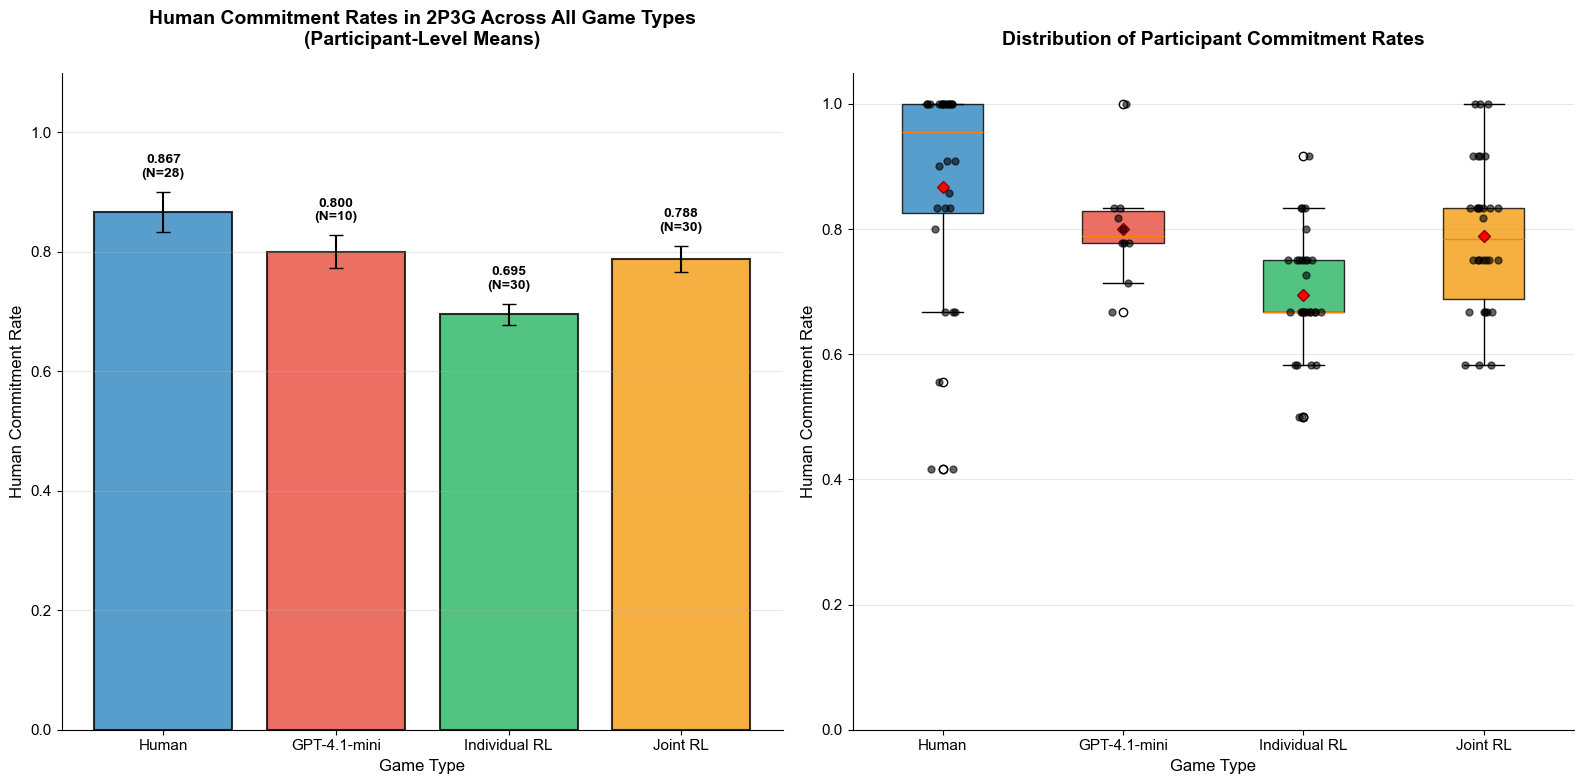

✅ Human commitment analysis complete with 108 participants


In [20]:
# Figure 8: Human Commitment Analysis (merged_commitment_analysis_2p3g.png)
if not data['trial_data'].empty:
    print("=== HUMAN COMMITMENT ANALYSIS ===")

    # Filter commitment data
    commitment_data = data['trial_data'][~pd.isna(data['trial_data']['human_commitment'])].copy()

    if not commitment_data.empty:
        commitment_data['participant_id'] = commitment_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        # Calculate participant-level commitment rates
        participant_commitment = commitment_data.groupby(['participant_id', 'game_type', 'study'])['human_commitment'].mean().reset_index()
        participant_commitment['commitment_rate'] = participant_commitment['human_commitment']

        available_commitment_types = [gt for gt in game_type_order if gt in participant_commitment['game_type'].values]
        available_commitment_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_commitment_types]
        available_commitment_colors = [CONDITION_COLORS[gt] for gt in available_commitment_types]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Bar plot
        plot_data, plot_errors, plot_ns = [], [], []

        for game_type in available_commitment_types:
            participant_data = participant_commitment[participant_commitment['game_type'] == game_type]['commitment_rate']
            plot_data.append(participant_data.mean())
            plot_errors.append(participant_data.std() / np.sqrt(len(participant_data)))
            plot_ns.append(len(participant_data))

        bars = ax1.bar(available_commitment_labels, plot_data, yerr=plot_errors, capsize=5,
                       alpha=0.8, color=available_commitment_colors, edgecolor='black', linewidth=1.5)

        for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                    f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax1.set_title('Human Commitment Rates in 2P3G Across All Game Types\n(Participant-Level Means)', fontweight='bold', pad=20)
        ax1.set_ylabel('Human Commitment Rate')
        ax1.set_xlabel('Game Type')
        ax1.set_ylim(0, 1.1)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # Box plot
        box_data = [participant_commitment[participant_commitment['game_type'] == gt]['commitment_rate'].values
                    for gt in available_commitment_types]

        bp = ax2.boxplot(box_data, labels=available_commitment_labels, patch_artist=True,
                         showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

        for patch, color in zip(bp['boxes'], available_commitment_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

        for i, game_type in enumerate(available_commitment_types):
            participant_data = participant_commitment[participant_commitment['game_type'] == game_type]['commitment_rate']
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

        ax2.set_title('Distribution of Participant Commitment Rates', fontweight='bold', pad=20)
        ax2.set_ylabel('Human Commitment Rate')
        ax2.set_xlabel('Game Type')
        ax2.set_ylim(0, 1.05)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.savefig('merged_commitment_analysis_2p3g.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Human commitment analysis complete with {len(participant_commitment)} participants")
    else:
        print("❌ No commitment data available")
else:
    print("❌ No trial data available for commitment analysis")

=== HUMAN COMMITMENT ANALYSIS - CLOSER CONDITIONS ONLY ===


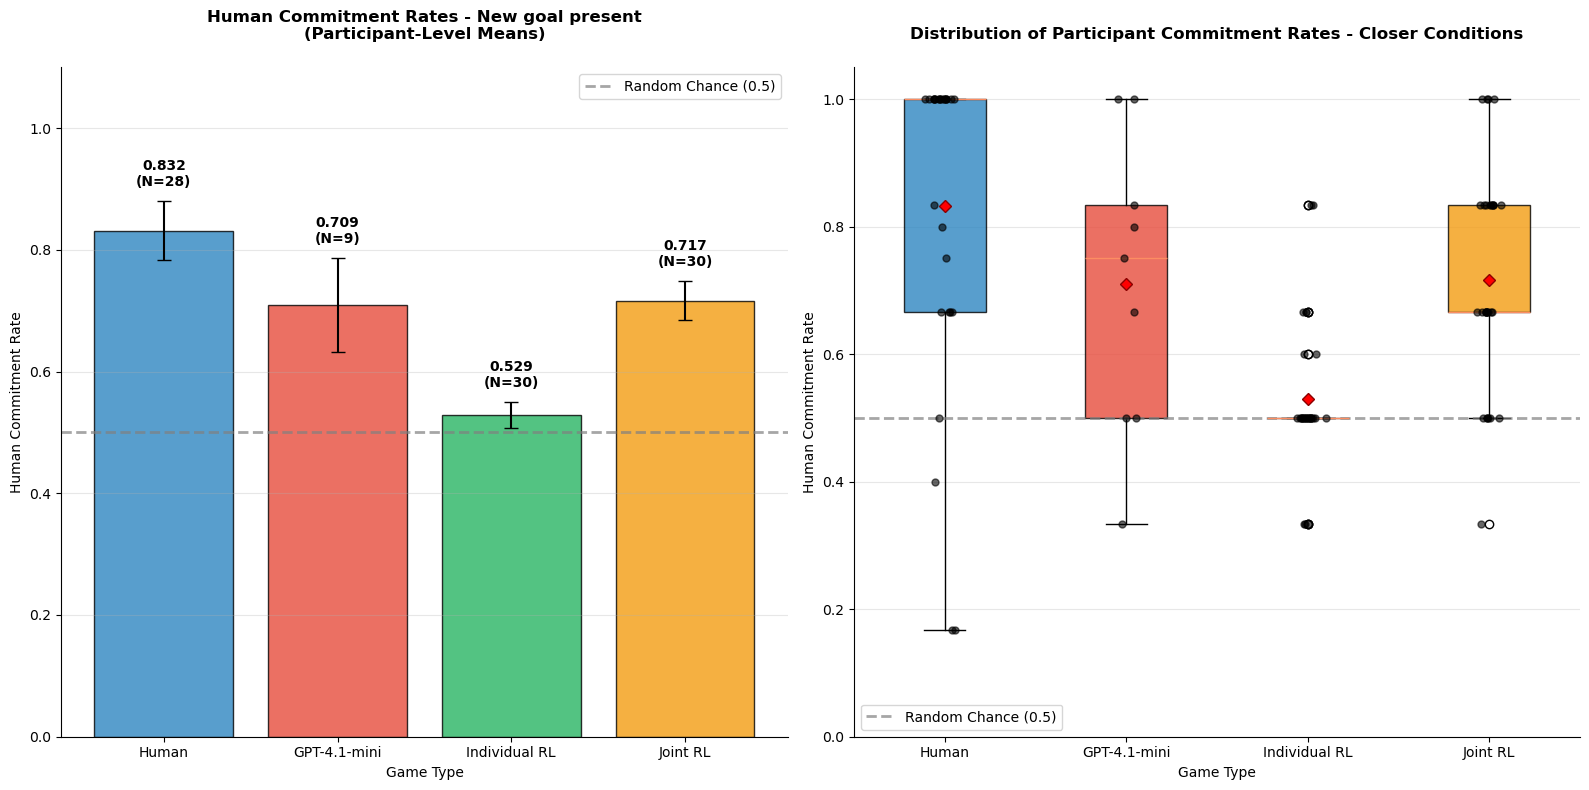

✅ Human commitment analysis (new goal conditions) complete with 107 participants
Total trials analyzed: 585


In [42]:
# Figure 8.5: Human Commitment Analysis - Closer Conditions Only (merged_commitment_closer_conditions_2p3g.png)
if not data['trial_data'].empty:
    print("=== HUMAN COMMITMENT ANALYSIS - CLOSER CONDITIONS ONLY ===")

    # Filter for closer conditions only
    closer_data = data['trial_data'][
        (~pd.isna(data['trial_data']['human_commitment'])) &
        (data['trial_data']['distanceCondition'].isin(['closer_to_player1', 'closer_to_player2']))
    ].copy()

    if not closer_data.empty:
        closer_data['participant_id'] = closer_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        # Create participant-level commitment means for closer conditions
        participant_closer_commitment = closer_data.groupby(
            ['participant_id', 'game_type', 'study']
        )['human_commitment'].mean().reset_index()
        participant_closer_commitment['commitment_rate'] = participant_closer_commitment['human_commitment']

        available_commitment_types = [gt for gt in game_type_order if gt in participant_closer_commitment['game_type'].values]
        available_commitment_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_commitment_types]
        available_commitment_colors = [CONDITION_COLORS[gt] for gt in available_commitment_types]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Bar plot
        plot_data, plot_errors, plot_ns = [], [], []

        for game_type in available_commitment_types:
            game_data = participant_closer_commitment[participant_closer_commitment['game_type'] == game_type]['commitment_rate']
            if len(game_data) > 0:
                plot_data.append(game_data.mean())
                plot_errors.append(game_data.sem())
                plot_ns.append(len(game_data))
            else:
                plot_data.append(0)
                plot_errors.append(0)
                plot_ns.append(0)

        bars = ax1.bar(available_commitment_labels, plot_data, yerr=plot_errors,
                      capsize=5, color=available_commitment_colors, alpha=0.8, edgecolor='black', linewidth=1)

        # Add random chance baseline
        ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Random Chance (0.5)')

        for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                    f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=10)

        ax1.set_title('Human Commitment Rates - New goal present\n(Participant-Level Means)', fontweight='bold', pad=20)
        ax1.set_ylabel('Human Commitment Rate')
        ax1.set_xlabel('Game Type')
        ax1.set_ylim(0, 1.1)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.legend()

        # Box plot
        box_data = [participant_closer_commitment[participant_closer_commitment['game_type'] == gt]['commitment_rate'].values
                    for gt in available_commitment_types]

        bp = ax2.boxplot(box_data, labels=available_commitment_labels, patch_artist=True,
                         showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

        # Add random chance baseline
        ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Random Chance (0.5)')

        for patch, color in zip(bp['boxes'], available_commitment_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

        for i, game_type in enumerate(available_commitment_types):
            participant_data = participant_closer_commitment[participant_closer_commitment['game_type'] == game_type]['commitment_rate']
            x_positions = np.random.normal(i+1, 0.04, size=len(participant_data))
            ax2.scatter(x_positions, participant_data, color='black', alpha=0.6, s=25, zorder=3)

        ax2.set_title('Distribution of Participant Commitment Rates - Closer Conditions', fontweight='bold', pad=20)
        ax2.set_ylabel('Human Commitment Rate')
        ax2.set_xlabel('Game Type')
        ax2.set_ylim(0, 1.05)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.legend()

        plt.tight_layout()
        plt.savefig('merged_commitment_closer_conditions_2p3g.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Human commitment analysis (new goal conditions) complete with {len(participant_closer_commitment)} participants")
        print(f"Total trials analyzed: {len(closer_data)}")
    else:
        print("❌ No commitment data available for closer conditions")
else:
    print("❌ No trial data available for commitment analysis")


## 6. Human Commitment by Distance Condition

=== HUMAN COMMITMENT BY DISTANCE CONDITIONS ===


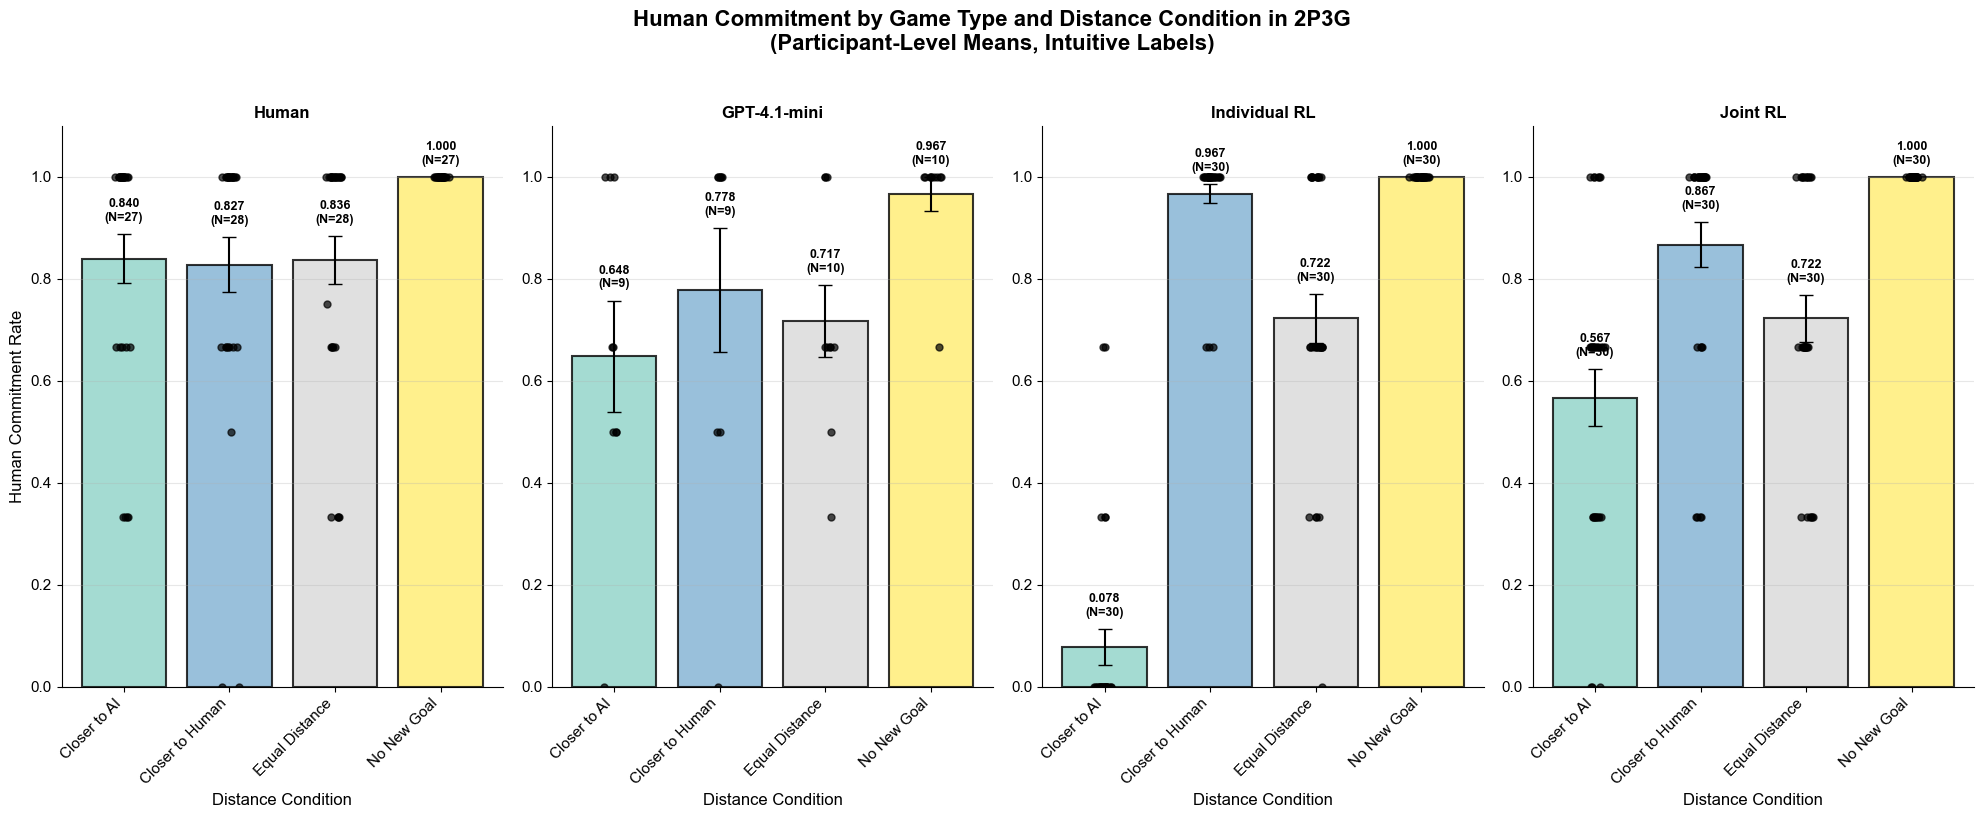

✅ Human commitment by distance analysis complete


In [21]:
# Figure 9: Human Commitment by Distance Condition (merged_commitment_by_distance_condition_2p3g.png)
if not data['trial_data'].empty:
    print("=== HUMAN COMMITMENT BY DISTANCE CONDITIONS ===")

    # Filter commitment data with distance conditions
    commitment_data = data['trial_data'][
        (~pd.isna(data['trial_data']['human_commitment'])) &
        (~pd.isna(data['trial_data']['distanceCondition_renamed']))
    ].copy()

    if not commitment_data.empty:
        commitment_data['participant_id'] = commitment_data.apply(
            lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
        )

        # Create participant-level commitment means by distance condition
        participant_distance_commitment = commitment_data.groupby(
            ['participant_id', 'game_type', 'study', 'distanceCondition_renamed']
        )['human_commitment'].mean().reset_index()
        participant_distance_commitment['commitment_rate'] = participant_distance_commitment['human_commitment']

        distance_conditions = sorted(participant_distance_commitment['distanceCondition_renamed'].unique())
        available_commitment_types = [gt for gt in game_type_order if gt in participant_distance_commitment['game_type'].values]
        available_commitment_labels = [game_type_labels[game_type_order.index(gt)] for gt in available_commitment_types]

        distance_colors = plt.cm.Set3(np.linspace(0, 1, len(distance_conditions)))

        fig, axes = plt.subplots(1, len(available_commitment_types), figsize=(5 * len(available_commitment_types), 8))
        if len(available_commitment_types) == 1:
            axes = [axes]

        for i, game_type in enumerate(available_commitment_types):
            ax = axes[i]
            game_label = available_commitment_labels[i]

            game_data = participant_distance_commitment[participant_distance_commitment['game_type'] == game_type]

            if len(game_data) > 0:
                plot_data, plot_errors, plot_ns, plot_labels, plot_colors = [], [], [], [], []

                for j, distance_condition in enumerate(distance_conditions):
                    distance_game_data = game_data[game_data['distanceCondition_renamed'] == distance_condition]['commitment_rate']
                    if len(distance_game_data) > 0:
                        plot_data.append(distance_game_data.mean())
                        plot_errors.append(distance_game_data.std() / np.sqrt(len(distance_game_data)))
                        plot_ns.append(len(distance_game_data))

                        # Create human-friendly label
                        if distance_condition == 'no_new_goal':
                            label = 'No New Goal'
                        elif distance_condition == 'closer_to_human':
                            label = 'Closer to Human'
                        elif distance_condition == 'closer_to_AI':
                            label = 'Closer to AI'
                        elif distance_condition == 'equal_to_both':
                            label = 'Equal Distance'
                        else:
                            label = str(distance_condition)

                        plot_labels.append(label)
                        plot_colors.append(distance_colors[j])

                if plot_data:
                    bars = ax.bar(range(len(plot_labels)), plot_data, yerr=plot_errors, capsize=5,
                                  alpha=0.8, color=plot_colors, edgecolor='black', linewidth=1.5)

                    ax.set_xticks(range(len(plot_labels)))
                    ax.set_xticklabels(plot_labels, rotation=45, ha='right')

                    # Add individual participant points
                    for j, distance_condition in enumerate(distance_conditions):
                        distance_game_data = game_data[game_data['distanceCondition_renamed'] == distance_condition]['commitment_rate']
                        if len(distance_game_data) > 0:
                            x_positions = np.random.normal(j, 0.04, size=len(distance_game_data))
                            ax.scatter(x_positions, distance_game_data, color='black', alpha=0.7, s=25, zorder=3)

                    # Add value labels
                    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
                        ax.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=9)

            ax.set_title(f'{game_label}', fontweight='bold', fontsize=12)
            ax.set_ylabel('Human Commitment Rate' if i == 0 else '')
            ax.set_xlabel('Distance Condition')
            ax.set_ylim(0, 1.1)
            ax.grid(True, alpha=0.3, axis='y')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        plt.suptitle('Human Commitment by Game Type and Distance Condition in 2P3G\n(Participant-Level Means, Intuitive Labels)',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('merged_commitment_by_distance_condition_2p3g.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Human commitment by distance analysis complete")
    else:
        print("❌ No commitment by distance data available")
else:
    print("❌ No trial data available for commitment by distance analysis")

## 7. AI Commitment by Distance Condition

=== AI COMMITMENT BY DISTANCE CONDITIONS ===


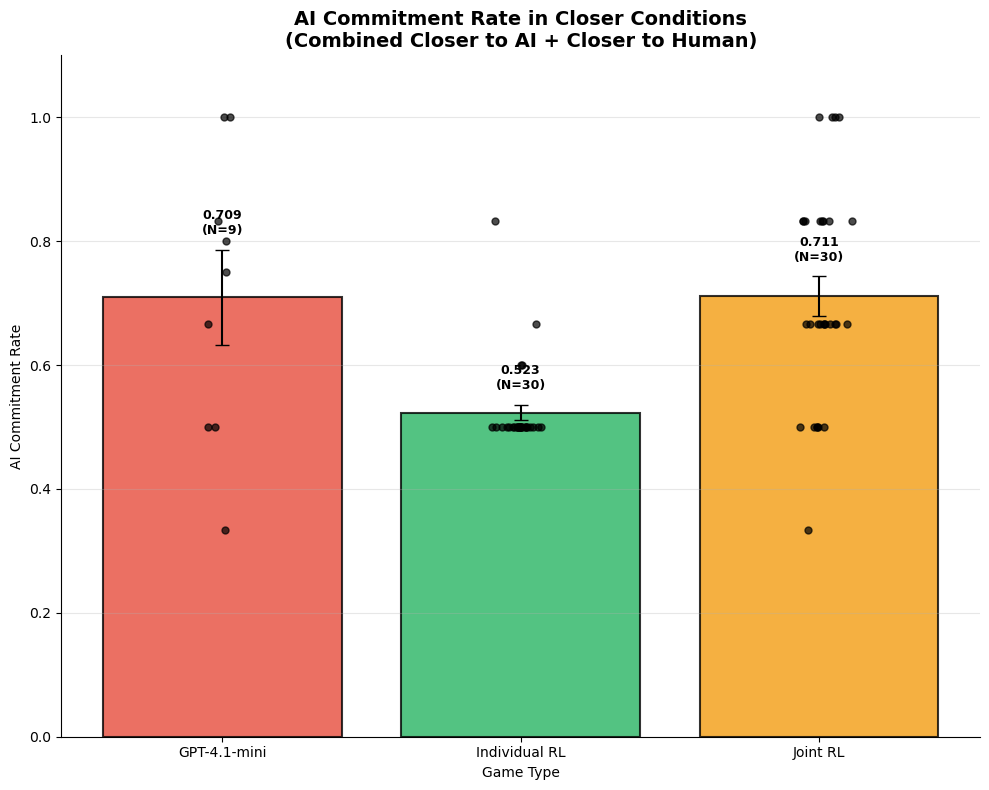

✅ AI commitment by distance analysis complete (closer conditions combined)


In [53]:
# Figure 10: AI Commitment by Distance Condition (merged_ai_commitment_by_distance_condition_2p3g.png)
if not data['trial_data'].empty:
    print("=== AI COMMITMENT BY DISTANCE CONDITIONS ===")

    # Filter to human-AI game types and calculate AI commitment
    human_ai_types = ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
    ai_commitment_data = data['trial_data'][
        (data['trial_data']['game_type'].isin(human_ai_types)) &
        (~pd.isna(data['trial_data']['distanceCondition_renamed']))
    ].copy()

    if not ai_commitment_data.empty:
        # Calculate AI commitment for trials that don't have it yet
        if 'ai_commitment' not in ai_commitment_data.columns or ai_commitment_data['ai_commitment'].isna().any():
            ai_commitment_data['ai_commitment'] = ai_commitment_data.apply(
                lambda row: calculate_ai_commitment_2p3g(
                    row, 'Human-RL' if row['game_type'] in ['individual_rl', 'joint_rl'] else 'Human-Human-GPT'
                ), axis=1
            )

        ai_commitment_data = ai_commitment_data.dropna(subset=['ai_commitment'])

        if not ai_commitment_data.empty:
            ai_commitment_data['participant_id'] = ai_commitment_data.apply(
                lambda row: extract_participant_id(row['file_id'], row['study']), axis=1
            )

            # Filter to only closer conditions and combine them
            closer_conditions = ['closer_to_AI', 'closer_to_human']
            ai_commitment_closer = ai_commitment_data[
                ai_commitment_data['distanceCondition_renamed'].isin(closer_conditions)
            ].copy()

            if not ai_commitment_closer.empty:
                # Create participant-level AI commitment by combining closer conditions
                ai_participant_commitment = ai_commitment_closer.groupby(
                    ['participant_id', 'game_type']
                )['ai_commitment'].mean().reset_index()
                ai_participant_commitment['ai_commitment_rate'] = ai_participant_commitment['ai_commitment']

                ai_game_types = ['gpt-4.1-mini', 'individual_rl', 'joint_rl']
                ai_game_labels = ['GPT-4.1-mini', 'Individual RL', 'Joint RL']
                available_ai_types = [gt for gt in ai_game_types if gt in ai_participant_commitment['game_type'].values]
                available_ai_labels = [ai_game_labels[ai_game_types.index(gt)] for gt in available_ai_types]

                # Create single plot with all three game types
                fig, ax = plt.subplots(1, 1, figsize=(10, 8))

                plot_data, plot_errors, plot_ns, plot_colors = [], [], [], []
                for i, game_type in enumerate(available_ai_types):
                    game_data = ai_participant_commitment[ai_participant_commitment['game_type'] == game_type]['ai_commitment_rate']
                    if len(game_data) > 0:
                        plot_data.append(game_data.mean())
                        plot_errors.append(game_data.std() / np.sqrt(len(game_data)))
                        plot_ns.append(len(game_data))
                        plot_colors.append(CONDITION_COLORS[game_type])

                if plot_data:
                    bars = ax.bar(range(len(available_ai_labels)), plot_data, yerr=plot_errors, capsize=5,
                                  alpha=0.8, color=plot_colors, edgecolor='black', linewidth=1.5)
                    ax.set_xticks(range(len(available_ai_labels)))
                    ax.set_xticklabels(available_ai_labels)

                    # Add individual participant points
                    for i, game_type in enumerate(available_ai_types):
                        game_data = ai_participant_commitment[ai_participant_commitment['game_type'] == game_type]['ai_commitment_rate']
                        if len(game_data) > 0:
                            x_positions = np.random.normal(i, 0.04, size=len(game_data))
                            ax.scatter(x_positions, game_data, color='black', alpha=0.7, s=25, zorder=3)

                    # Add value labels
                    for bar, mean_val, error_val, n in zip(bars, plot_data, plot_errors, plot_ns):
                        ax.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                                f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom', fontweight='bold', fontsize=9)

                ax.set_title('AI Commitment Rate in Closer Conditions\n(Combined Closer to AI + Closer to Human)',
                            fontweight='bold', fontsize=14)
                ax.set_ylabel('AI Commitment Rate')
                ax.set_xlabel('Game Type')
                ax.set_ylim(0, 1.1)
                ax.grid(True, alpha=0.3, axis='y')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                plt.tight_layout()
                plt.savefig('merged_ai_commitment_by_distance_condition_2p3g.png', dpi=300, bbox_inches='tight')
                plt.show()

                print(f"✅ AI commitment by distance analysis complete (closer conditions combined)")
            else:
                print("❌ No closer condition data available")
        else:
            print("❌ No AI commitment data available after processing")
    else:
        print("❌ No AI commitment by distance data available")
else:
    print("❌ No trial data available for AI commitment analysis")